# Image processing → segmentation → feature extraction pipeline

#### 1. Introduction

- **Objective**: Classify paintings based on extracted features.
- **Tasks**:
    - Loads 4 painting images.
    - Preprocesses (background removal and region of interest extraction).
    - Segments red / yellow / blue regions.
    - Morphology per color mask: clean each mask individually
    - Extracts features: aspect ratio, per-color centers of mass, distances to painting center.
    - Evaluates feature quality (informativeness, discriminative power, independence, uniqueness).
    - Performs univariate analysis (histogram, boxplot, scatter), and correlation checks.
    - Prepares features for a classification task (clear objective & metrics).
- **Expected Outcome**: Feature set that is informative, discriminative, and robust for classification.

#### 2. Load and Display Images

In this step we:
- Load the 4 images from the dataset folder.
- Convert them to RGB for visualization (OpenCV loads BGR).
- Display them inline to verify correctness.
- Save references to the loaded images for downstream steps.

In [69]:
from matplotlib import pyplot as plt
from pathlib import Path
import cv2 as cv
import os
import numpy as np
from scipy.stats import entropy
import pandas as pd

In [ ]:
def display_image(img, title=None,):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

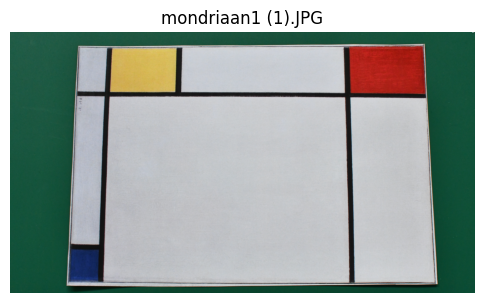

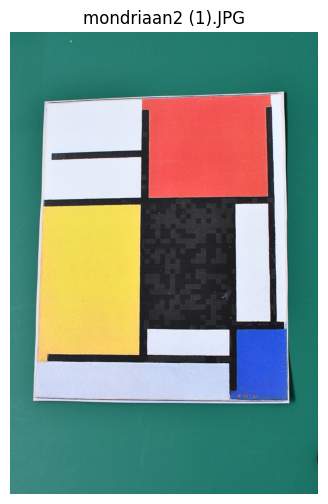

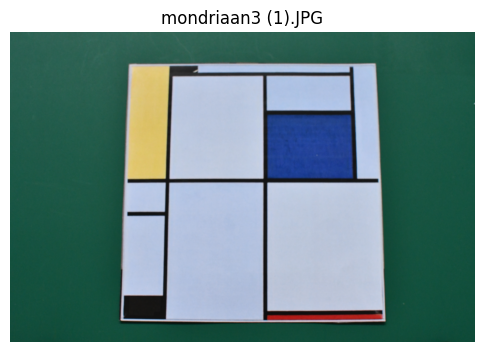

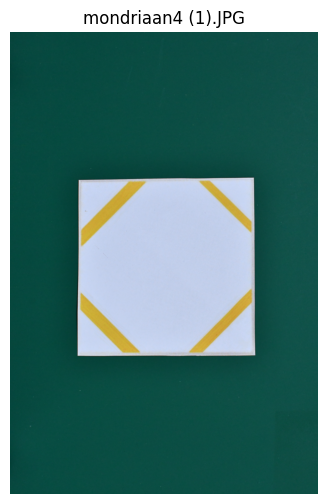

In [ ]:
folder_path = Path(r'C:\workspace\evml\EVD3\workspace\data')

files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

imgs_bgr = [cv.imread(str(folder_path / f)) for f in files]
imgs_rgb = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in imgs_bgr]

for fname, img_rgb in zip(files, imgs_rgb):
    display_image(img_rgb, title=fname)


#### Step 2b — Background Hue Analysis

Before applying morphology, we need to identify which hue ranges correspond to the background.  
Steps:
1. Mask the painting region.  
2. Display the masked image.  
3. Plot the hue histogram.  
4. Note dominant hue peaks that represent background colors. 

In [12]:
def maskColor(img, min_hue, max_hue, invert=False):
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    light = (min_hue,50,50)
    dark  = (max_hue,255,255)
    mask = cv.inRange(img_hsv, light, dark)
    if invert:
        mask = cv.bitwise_not(mask)

    return mask

In [16]:
def create_hue_histogram(img: np.ndarray, s_threshold: int = 30, v_threshold: int = 30, center_hue: int = -1) -> np.ndarray:
    hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    h, s, v = cv.split(hsv)

    # Shift hue if center_hue is specified
    if 0 <= center_hue <= 179:
        h = (h - center_hue + 90) % 180    

    # Create a mask for meaningful colors
    mask = cv.bitwise_and(cv.inRange(s, s_threshold, 255), cv.inRange(v, v_threshold, 255))
    
    # Calculate histogram for masked hue values
    hist = cv.calcHist([h], [0], mask, [180], [0, 180])

    # Normalize the histogram
    cv.normalize(hist, hist, 0, 1, cv.NORM_MINMAX)    
    
    return hist

In [14]:
from matplotlib.colors import hsv_to_rgb

def plot_hue_histogram(hist: np.ndarray, center_hue: int = -1):
    _, (ax_hist, ax_color) = plt.subplots(
        2, 
        1, 
        figsize=(10, 6), 
        gridspec_kw={'height_ratios': [4, 1]}, 
        sharex=True
    )
    
    # Plot the histogram
    ax_hist.plot(hist.ravel())
    ax_hist.set_title('Hue Histogram')
    ax_hist.set_ylabel('Frequency')
    ax_hist.set_xlim([0, 180])
    
    # Create a color array for the colorbar
    hue_range = np.linspace(0, 1, 180)
    saturation = np.ones_like(hue_range)
    value = np.ones_like(hue_range)
    hsv_colors = np.stack((hue_range, saturation, value), axis=1)
    rgb_colors = hsv_to_rgb(hsv_colors)
    
    # Plot the color chart
    ax_color.imshow([rgb_colors], aspect='auto', extent=[0, 180, 0, 1])
    ax_color.set_yticks([])
    
    # Set x-axis label
    plt.xlabel('Hue Value' + (' (Shifted)' if 0 <= center_hue <= 179 else ''))
    
    plt.tight_layout()
    plt.show()

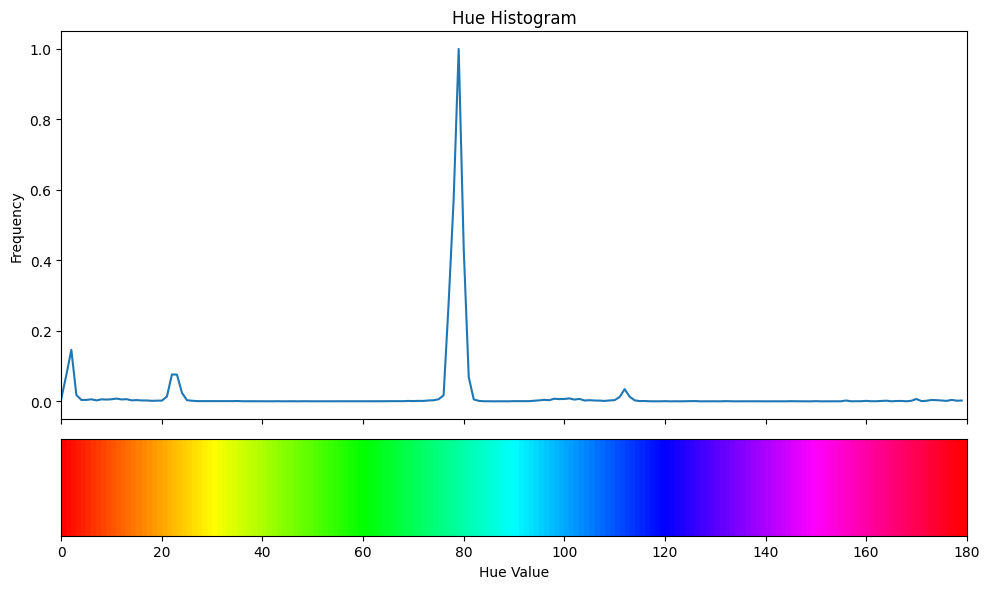

In [20]:
img_rgb = imgs_rgb[0]

hist = create_hue_histogram(img_rgb)

plot_hue_histogram(hist)

##### Observations

- Peaks in the histogram indicate dominant hues in the painting.  
- The background hue(s) can be identified if they form sharp peaks outside the expected red, yellow, and blue regions.  

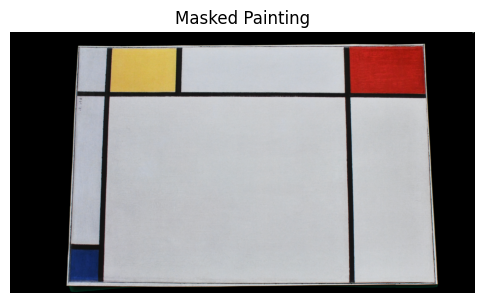

In [33]:
background_hue_range = 67, 95

mask = maskColor(img_rgb, background_hue_range[0], background_hue_range[1], True)
masked_img = cv.bitwise_and(img_rgb, img_rgb, mask=mask)

display_image(masked_img, title="Masked Painting")

#### Step 3 — Preprocessing (Background Removal, ROI extraction)

This step combines:
1. **Background removal**: mask the painting region using `maskColor`.  
2. **ROI extraction**: crop the painting via largest contour.  

#### Step 3a — ROI Extraction

We now crop the region of interest (ROI) — the painting itself — from the masked image.
Steps:
1. Convert masked image to grayscale.
2. Find the largest contour (assumed to be the painting).
3. Extract bounding box (left, right, top, bottom).
4. Crop the ROI.


In [ ]:
def getLargestContour(img_BW):
    contours, _ = cv.findContours(img_BW.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv.contourArea)

    return np.squeeze(contour)

def getContourExtremes(contour):
    left = contour[contour[:, 0].argmin()]
    right = contour[contour[:, 0].argmax()]
    top = contour[contour[:, 1].argmin()]
    bottom = contour[contour[:, 1].argmax()]

    return np.array((left, right, top, bottom))

ROI boundaries: [ 674 3023] [5127 3021] [4943  151] [ 764 3116]


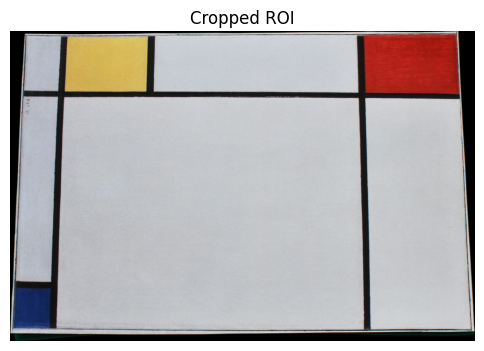

In [36]:
gray = cv.cvtColor(masked_img, cv.COLOR_RGB2GRAY)
contour = getLargestContour(gray)

left, right, top, bottom = getContourExtremes(contour)
x_min, x_max = left[0], right[0]
y_min, y_max = top[1], bottom[1]

cropped_img = masked_img[y_min:y_max, x_min:x_max]

print("ROI boundaries:", left, right, top, bottom)
display_image(cropped_img, title="Cropped ROI")


##### Observations



In [68]:
def preprocess_image(img_rgb):
    """
    Preprocess a painting image.
    Steps:
    1. Remove background
    2. Extract ROI using largest contour
    Returns:
        cropped_img
    """
    # --- Background removal ---
    mask = maskColor(img_rgb, 67, 85, True)
    masked_img = cv.bitwise_and(img_rgb, img_rgb, mask=mask)

    # --- Extract ROI via largest contour ---
    gray = cv.cvtColor(masked_img, cv.COLOR_RGB2GRAY)
    contour = getLargestContour(gray)
    left, right, top, bottom = getContourExtremes(contour)
    x_min, x_max = left[0], right[0]
    y_min, y_max = top[1], bottom[1]
    cropped_img = masked_img[y_min:y_max, x_min:x_max]

    return cropped_img

#### Step 4 — Color Segmentation

Objective:
- Extract red, yellow, and blue regions from the painting.
- Prepare binary masks for feature extraction.

Steps:
1. Define hue ranges for each color in HSV space.
2. Create binary masks for each color.
3. Display masks to verify segmentation.
4. Optionally create inverse masks for removing color regions from the painting.


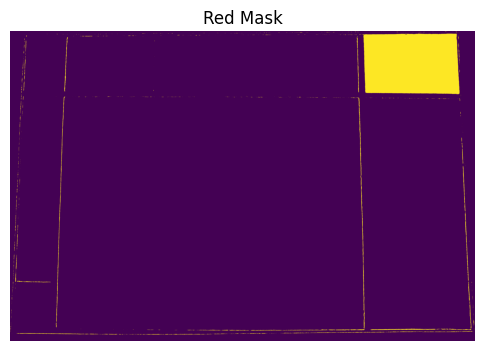

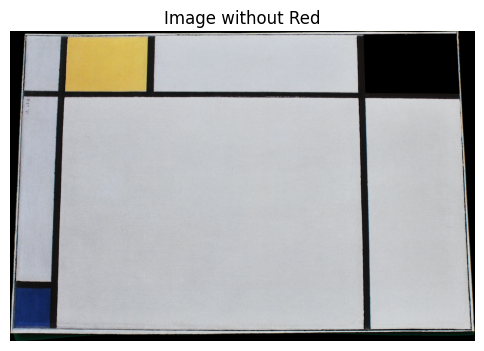

In [41]:
# Red mask (hue wrap-around in HSV)
mask_upper = maskColor(cropped_img, 0, 11, False)      # lower red hue
mask_lower = maskColor(cropped_img, 169, 180, False)  # upper red hue
red_mask = cv.bitwise_or(mask_upper, mask_lower)

# Display red mask
display_image(red_mask, title="Red Mask")

# Optional: inverse mask & image without red
not_red_mask = cv.bitwise_not(red_mask)
img_no_red = cv.bitwise_and(cropped_img, cropped_img, mask=not_red_mask)
display_image(img_no_red, title="Image without Red")


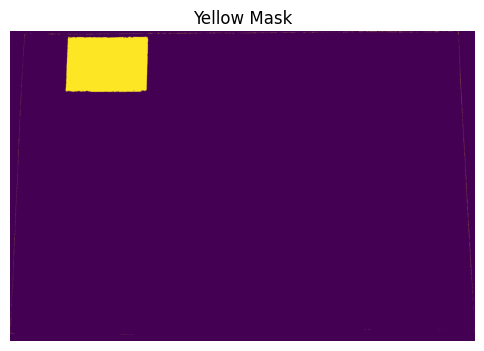

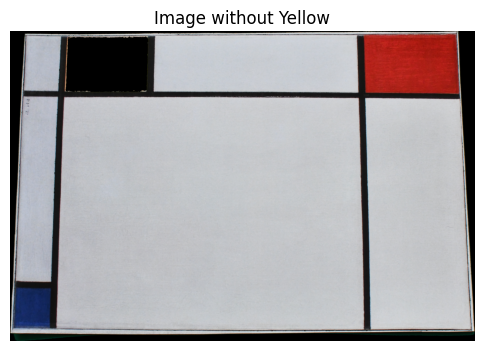

In [42]:
# Yellow hue range
yellow_mask = maskColor(cropped_img, 20, 35, False)

# Display yellow mask
display_image(yellow_mask, title="Yellow Mask")

# Optional: inverse mask & image without yellow
not_yellow_mask = cv.bitwise_not(yellow_mask)
img_no_yellow = cv.bitwise_and(cropped_img, cropped_img, mask=not_yellow_mask)
display_image(img_no_yellow, title="Image without Yellow")


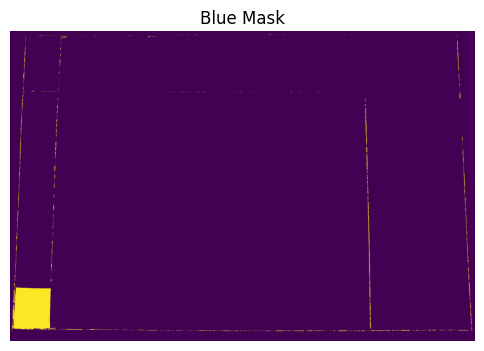

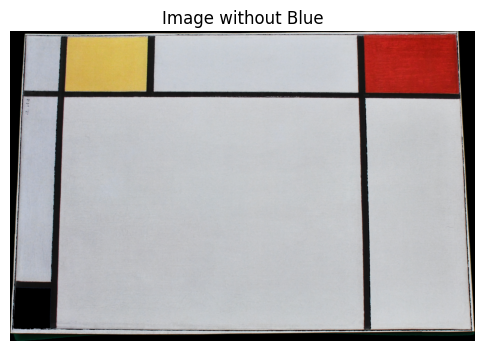

In [43]:
# Blue hue range
blue_mask = maskColor(cropped_img, 100, 130, False)

# Display blue mask
display_image(blue_mask, title="Blue Mask")

# Optional: inverse mask & image without blue
not_blue_mask = cv.bitwise_not(blue_mask)
img_no_blue = cv.bitwise_and(cropped_img, cropped_img, mask=not_blue_mask)
display_image(img_no_blue, title="Image without Blue")


#### Step 5 — Morphological Operations

We test morphological operations to reduce noise:
- **Erosion**: removes small dots but may shrink shapes.
- **Dilation**: fills gaps but may expand regions.
- **Opening (erode → dilate)**: removes small noise.
- **Closing (dilate → erode)**: closes small holes inside regions.
- **Open → Close**: often produces the cleanest result.


In [44]:
def apply_morph_operations(mask, masked_img, kernel_size=3):
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # 1. Erode
    eroded = cv.erode(mask, kernel, iterations=1)
    not_eroded = cv.bitwise_not(eroded)
    img_eroded = cv.bitwise_and(masked_img, masked_img, mask=not_eroded)

    # 2. Dilate
    dilated = cv.dilate(mask, kernel, iterations=1)
    not_dilated = cv.bitwise_not(dilated)
    img_dilated = cv.bitwise_and(masked_img, masked_img, mask=not_dilated)

    # 3. Close
    closed = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    not_closed = cv.bitwise_not(closed)
    img_closed = cv.bitwise_and(masked_img, masked_img, mask=not_closed)

    # 4. Open
    opened = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    not_opened = cv.bitwise_not(opened)
    img_opened = cv.bitwise_and(masked_img, masked_img, mask=not_opened)

    # 5. Open → Close
    open_close = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
    open_close = cv.morphologyEx(open_close, cv.MORPH_CLOSE, kernel)
    not_oc = cv.bitwise_not(open_close)
    img_oc = cv.bitwise_and(masked_img, masked_img, mask=not_oc)

    return {
        "erode": img_eroded,
        "dilate": img_dilated,
        "close": img_closed,
        "open": img_opened,
        "open_close": img_oc
    }


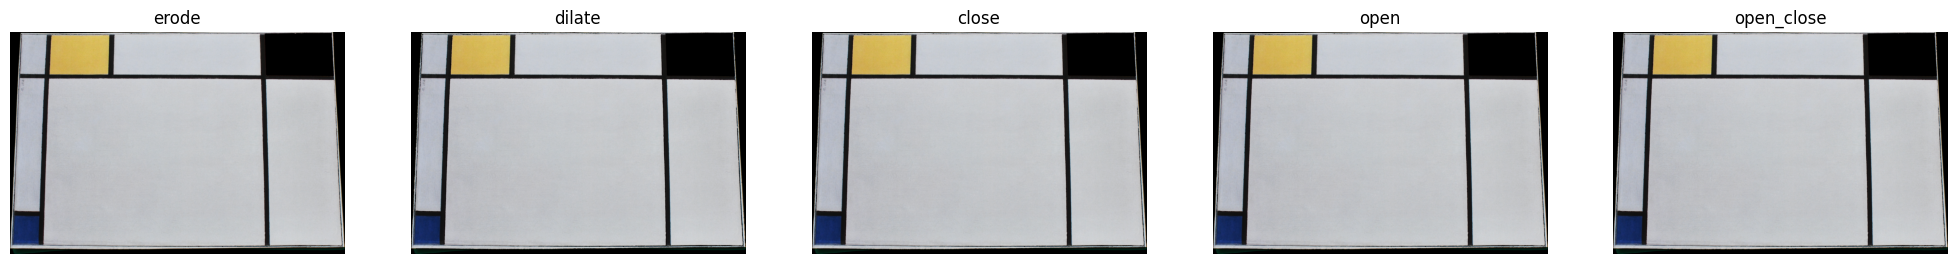

In [47]:
# Example: test morphology on red mask
morph_results = apply_morph_operations(red_mask, cropped_img, kernel_size=3)

# Display the results side-by-side
fig, axes = plt.subplots(1, len(morph_results), figsize=(25, 6))
for ax, (name, img) in zip(axes, morph_results.items()):
    ax.imshow(img)
    ax.set_title(name)
    ax.axis("off")
plt.show()



##### Observations

- Visual differences are minimal because color regions are large and clean.
- Morphology mainly removes tiny noise or fills small gaps.


#### Step 6 — Feature Extraction

**Objective:**  
- Compute numerical features from the cleaned color masks inside the cropped painting.

**Features:**  
1. **Aspect ratio** of the ROI  
2. **Center of mass (CoM)** for red, yellow, and blue regions  
3. **Distance from each color CoM** to the center of the painting (normalized by diagonal)  
4. **Color coverage / percentages** for red, yellow, and blue  
5. **Contour-based features** for each color:  
   - Area of the largest contour  
   - Perimeter of the largest contour  
6. **Color diversity features** (overall painting color richness):  
   - Entropy of hue histogram (`color_diversity`)  
   - Number of unique hues (`unique_hues`)  
   - Variance of hue values (`hue_variance`)


In [48]:
def color_percentage(mask):
    total_pixels = mask.size
    color_pixels = cv.countNonZero(mask)
    return (color_pixels / total_pixels) * 100

def center_of_mass(mask):
    moments = cv.moments(mask)
    if moments["m00"] == 0:
        return None  # no pixels in mask
    cx = moments["m10"] / moments["m00"]
    cy = moments["m01"] / moments["m00"]
    return (int(cx), int(cy))

def compute_aspect_ratio(image):
    height, width = image.shape[:2]
    if height == 0:
        return np.nan
    return width / height

def calc_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def color_diversity(img: np.ndarray, s_threshold=30, v_threshold=30) -> float:
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    mask = cv.bitwise_and(cv.inRange(s, s_threshold, 255),
                          cv.inRange(v, v_threshold, 255))
    hist = cv.calcHist([h], [0], mask, [180], [0, 180]).flatten()
    hist = hist / hist.sum() if hist.sum() > 0 else hist
    return float(entropy(hist + 1e-6))

def unique_hues(img: np.ndarray, threshold=0.01) -> int:
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    mask = cv.bitwise_and(cv.inRange(s, 30, 255), cv.inRange(v, 30, 255))
    hist = cv.calcHist([h], [0], mask, [180], [0, 180]).flatten()
    hist = hist / hist.sum() if hist.sum() > 0 else hist
    return int(np.sum(hist > threshold))

def hue_variance(img: np.ndarray) -> float:
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    mask = (s > 30) & (v > 30)
    return float(np.var(h[mask]))

def contour_features(mask: np.ndarray):
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return {'area': 0.0, 'perimeter': 0.0}
    largest = max(contours, key=cv.contourArea)
    area = cv.contourArea(largest)
    perimeter = cv.arcLength(largest, True)
    return {'area': area, 'perimeter': perimeter}


#### Step 6b — Feature Validation

Objective:
- Test each feature individually to verify it is computed correctly.
- Check values for reasonableness (e.g., non-negative, within expected ranges).
- Visualize some features when applicable (e.g., centers of mass).


In [50]:
aspect_ratio = compute_aspect_ratio(cropped_img)
print(f"Aspect ratio: {aspect_ratio:.2f}")

Aspect ratio: 1.50


In [51]:
# Image dimensions
h, w = cropped_img.shape[:2]
image_center = (w // 2, h // 2)

# Compute CoM directly on raw masks
com_red = center_of_mass(red_mask)
com_yellow = center_of_mass(yellow_mask)
com_blue = center_of_mass(blue_mask)

print("Centers of Mass:")
print(f"Red: {com_red}")
print(f"Yellow: {com_yellow}")
print(f"Blue: {com_blue}")
print(f"Painting center: {image_center}")


Centers of Mass:
Red: (3655, 520)
Yellow: (965, 330)
Blue: (756, 2430)
Painting center: (2226, 1482)


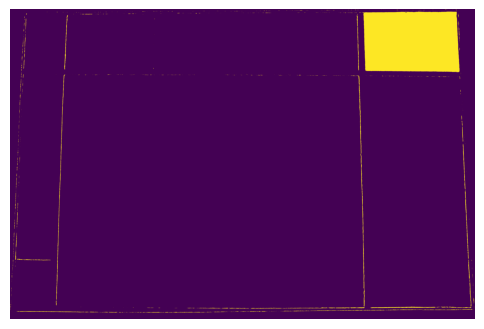

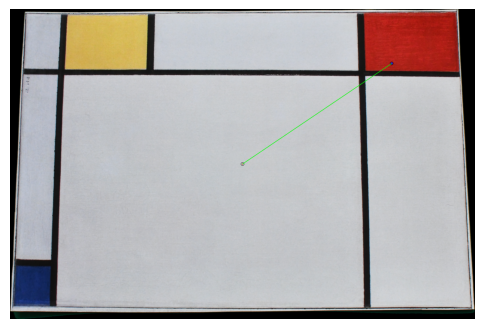

In [52]:
img_with_com = cropped_img.copy()

# Draw red CoM
cv.circle(img_with_com, com_red, radius=10, color=(0,0,255), thickness=-1)  # filled red dot
cv.circle(img_with_com, com_red, radius=15, color=(0,0,0), thickness=2)     # black border

# Draw painting center
cv.circle(img_with_com, image_center, radius=5, color=(255,0,0), thickness=-1)  # filled blue dot
cv.circle(img_with_com, image_center, radius=15, color=(0,0,0), thickness=2)    # black border

# Draw line connecting CoM to painting center
cv.line(img_with_com, image_center, com_red, color=(0,255,0), thickness=3)

# Display masks and overlay
display_image(red_mask)         # shows the red mask
display_image(img_with_com)     # shows the cropped painting with CoM, center, and connecting line


In [53]:
image_diag = np.sqrt(h**2 + w**2)

red_dist = calc_distance(com_red, image_center) / image_diag
yellow_dist = calc_distance(com_yellow, image_center) / image_diag
blue_dist = calc_distance(com_blue, image_center) / image_diag

print("\nNormalized Distances to Painting Center:")
print(f"Red: {red_dist:.3f}")
print(f"Yellow: {yellow_dist:.3f}")
print(f"Blue: {blue_dist:.3f}")


Normalized Distances to Painting Center:
Red: 0.322
Yellow: 0.319
Blue: 0.327


In [54]:
red_pct = color_percentage(red_mask)
yellow_pct = color_percentage(yellow_mask)
blue_pct = color_percentage(blue_mask)

print("Color Percentages:")
print(f"Red: {red_pct:.2f}%")
print(f"Yellow: {yellow_pct:.2f}%")
print(f"Blue: {blue_pct:.2f}%")


Color Percentages:
Red: 4.43%
Yellow: 3.11%
Blue: 1.38%


In [56]:
red_cont = contour_features(red_mask)
yellow_cont = contour_features(yellow_mask)
blue_cont = contour_features(blue_mask)

print("Contour Features:")
print(f"Red area/perimeter: {red_cont}")
print(f"Yellow area/perimeter: {yellow_cont}")
print(f"Blue area/perimeter: {blue_cont}")

Contour Features:
Red area/perimeter: {'area': 507677.5, 'perimeter': 3174.035701394081}
Yellow area/perimeter: {'area': 399823.5, 'perimeter': 3203.8144809007645}
Blue area/perimeter: {'area': 134815.5, 'perimeter': 2379.4225652217865}


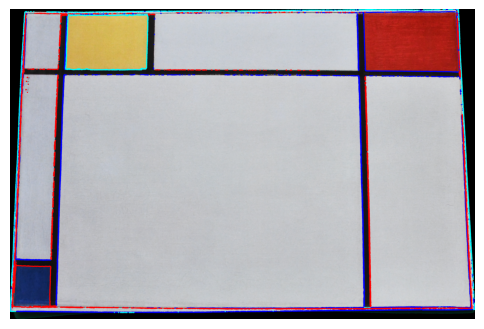

In [61]:
img_with_contours = cropped_img.copy()
contours_red, _ = cv.findContours(red_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_yellow, _ = cv.findContours(yellow_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_blue, _ = cv.findContours(blue_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

cv.drawContours(img_with_contours, contours_red, -1, (0,0,255), 10)
cv.drawContours(img_with_contours, contours_yellow, -1, (0,255,255), 10)
cv.drawContours(img_with_contours, contours_blue, -1, (255,0,0), 10)

display_image(img_with_contours)


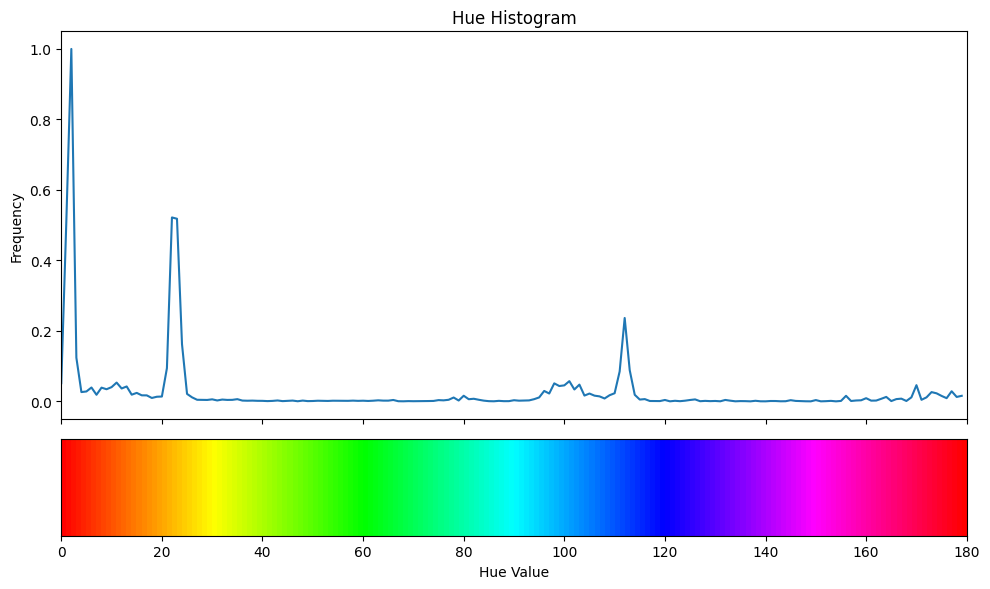

Color Diversity (entropy of hues): 3.345
Number of Unique Hues: 14
Hue Variance: 1602.528


In [67]:
# Create hue histogram using your function
hist = create_hue_histogram(cropped_img)

# Plot the histogram
plot_hue_histogram(hist)

# Compute features
diversity = color_diversity(cropped_img)
num_hues = unique_hues(cropped_img, threshold=0.01)
hue_var = hue_variance(cropped_img)

print(f"Color Diversity (entropy of hues): {diversity:.3f}")
print(f"Number of Unique Hues: {num_hues}")
print(f"Hue Variance: {hue_var:.3f}")


In [49]:
def extract_features(cropped_img, red_mask, yellow_mask, blue_mask):
    h, w = cropped_img.shape[:2]
    image_center = (w/2, h/2)
    image_diag = np.sqrt(w**2 + h**2)

    # Aspect ratio
    aspect_ratio = compute_aspect_ratio(cropped_img)

    # Centers of mass
    red_com = center_of_mass(red_mask)
    yellow_com = center_of_mass(yellow_mask)
    blue_com = center_of_mass(blue_mask)

    # Distances to center (normalized)
    red_dist = calc_distance(red_com, image_center) / image_diag
    yellow_dist = calc_distance(yellow_com, image_center) / image_diag
    blue_dist = calc_distance(blue_com, image_center) / image_diag

    # Color percentages
    red_pct = color_percentage(red_mask)
    yellow_pct = color_percentage(yellow_mask)
    blue_pct = color_percentage(blue_mask)

    # Contour features
    red_contour = contour_features(red_mask)
    yellow_contour = contour_features(yellow_mask)
    blue_contour = contour_features(blue_mask)

    # Color diversity / hue entropy
    diversity = color_diversity(cropped_img)

    # Unique hues
    unique = unique_hues(cropped_img)

    # Hue variance
    hue_var = hue_variance(cropped_img)

    # -------------------------------
    # Collect all features
    # -------------------------------
    features = {
        "aspect_ratio": aspect_ratio,
        "red_com": red_com,
        "yellow_com": yellow_com,
        "blue_com": blue_com,
        "red_dist": red_dist,
        "yellow_dist": yellow_dist,
        "blue_dist": blue_dist,
        "red_pct": red_pct,
        "yellow_pct": yellow_pct,
        "blue_pct": blue_pct,
        "red_area": red_contour['area'],
        "red_perimeter": red_contour['perimeter'],
        "yellow_area": yellow_contour['area'],
        "yellow_perimeter": yellow_contour['perimeter'],
        "blue_area": blue_contour['area'],
        "blue_perimeter": blue_contour['perimeter'],
        "color_diversity": diversity,
        "unique_hues": unique,
        "hue_variance": hue_var
    }

    return features

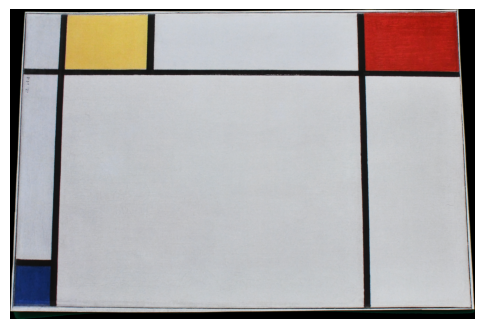

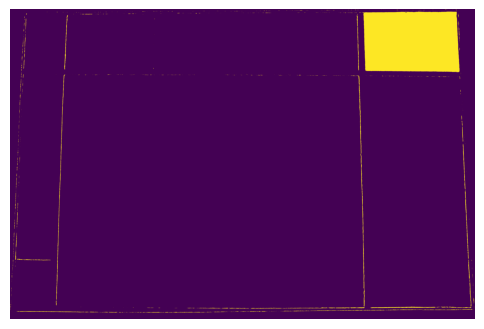

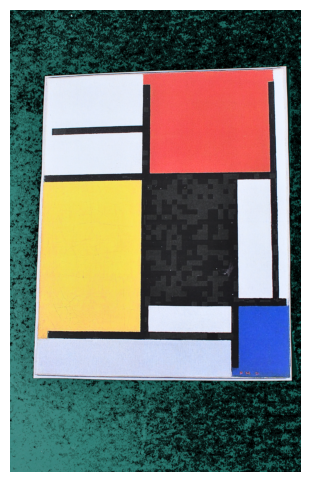

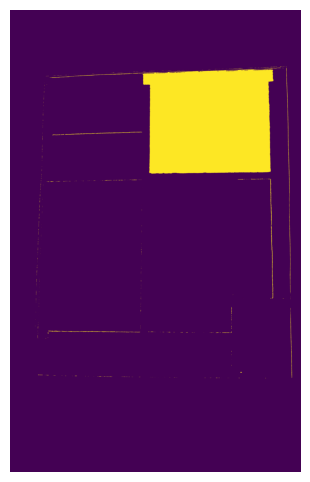

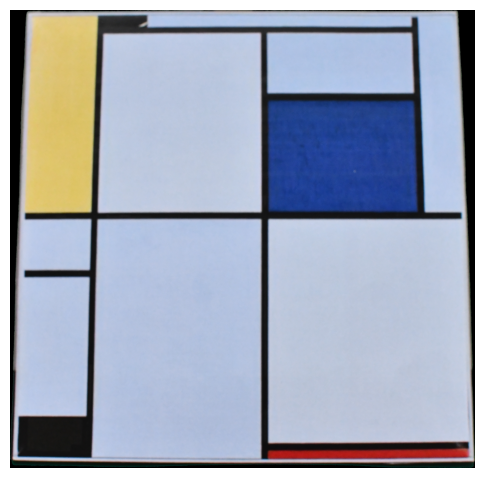

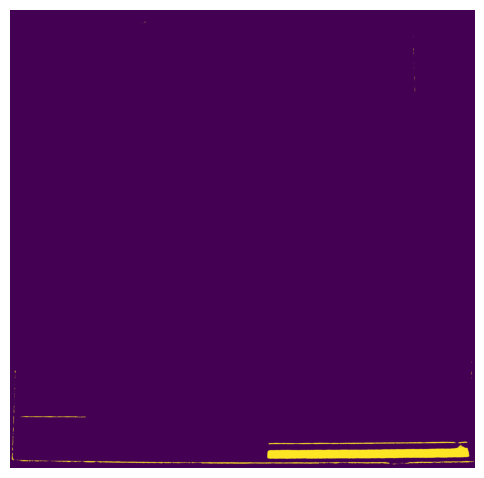

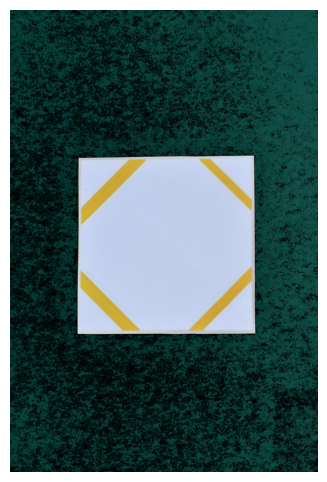

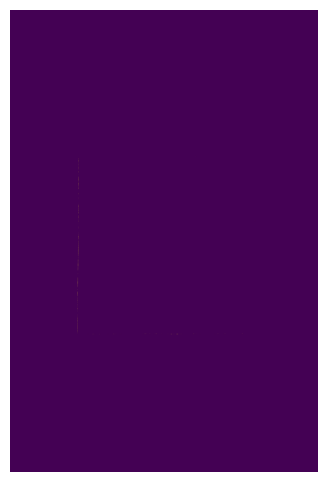

aspect_ratio       red_com    yellow_com      blue_com  red_dist  \
0      1.501855   (3655, 520)  (2263, 1516)  (2247, 1468)  0.321975   
1      0.629777  (2381, 1362)  (1827, 2742)  (1696, 2721)  0.235879   
2      1.015243  (2279, 3043)  (1676, 1626)  (1518, 1661)  0.360676   
3      0.666607   (921, 2996)  (1858, 2781)  (1855, 2783)  0.143241   

   yellow_dist  blue_dist   red_pct  yellow_pct   blue_pct   red_area  \
0     0.009261   0.004694  4.425218   97.119391  98.378712   507677.5   
1     0.013857   0.008893  9.414421   89.384658  96.318160  1762133.0   
2     0.020736   0.026332  1.150124   94.022312  71.042497    82486.0   
3     0.000528   0.000106  0.007096   97.824527  99.834887       31.5   

   red_perimeter  yellow_area  yellow_perimeter   blue_area  blue_perimeter  \
0    3174.035701   13195728.0           14832.0  13195728.0    14832.000000   
1    9726.471671   19187520.0           17992.0  19187517.0    17994.485281   
2    3093.650925   10061008.0           12688.0  10061008.0    12688.000000   
3     152.384776   20649860.0           18552.0  20649838.5    18570.041630   

   color_diversity  unique_hues  hue_variance            image_id  
0         3.356057           14   1611.628162  mondriaan1 (1).JPG  
1         2.994363           18   2069.674308  mondriaan2 (1).JPG  
2         2.296359           10    782.319701  mondriaan3 (1).JPG  
3         1.755007            9    295.659504  mondriaan4 (1).JPG

In [76]:
features_list = []

for fname, img_rgb in zip(files, imgs_rgb):
    # --- Preprocess: remve background and crop ROI ---
    cropped_img = preprocess_image(img_rgb)

    # --- Color segmentation ---
    mask_upper = maskColor(cropped_img, 0, 11, False)
    mask_lower = maskColor(cropped_img, 169, 180, False)
    red_mask = cv.bitwise_or(mask_upper, mask_lower)
    yellow_mask = maskColor(cropped_img, 22, 38, True)
    blue_mask = maskColor(cropped_img, 90, 130, True)
    
    display_image(cropped_img)
    display_image(red_mask)

    # --- Extract features ---
    feats = extract_features(cropped_img, red_mask, yellow_mask, blue_mask)
    feats['image_id'] = fname
    features_list.append(feats)

df_features = pd.DataFrame(features_list)
df_features

#### Step 7 — Feature Validation & Univariate Analysis

Objective:
- Inspect extracted features visually and numerically.
- Identify distributions, potential correlations, and outliers.
- Detect data quality issues and possible biases.

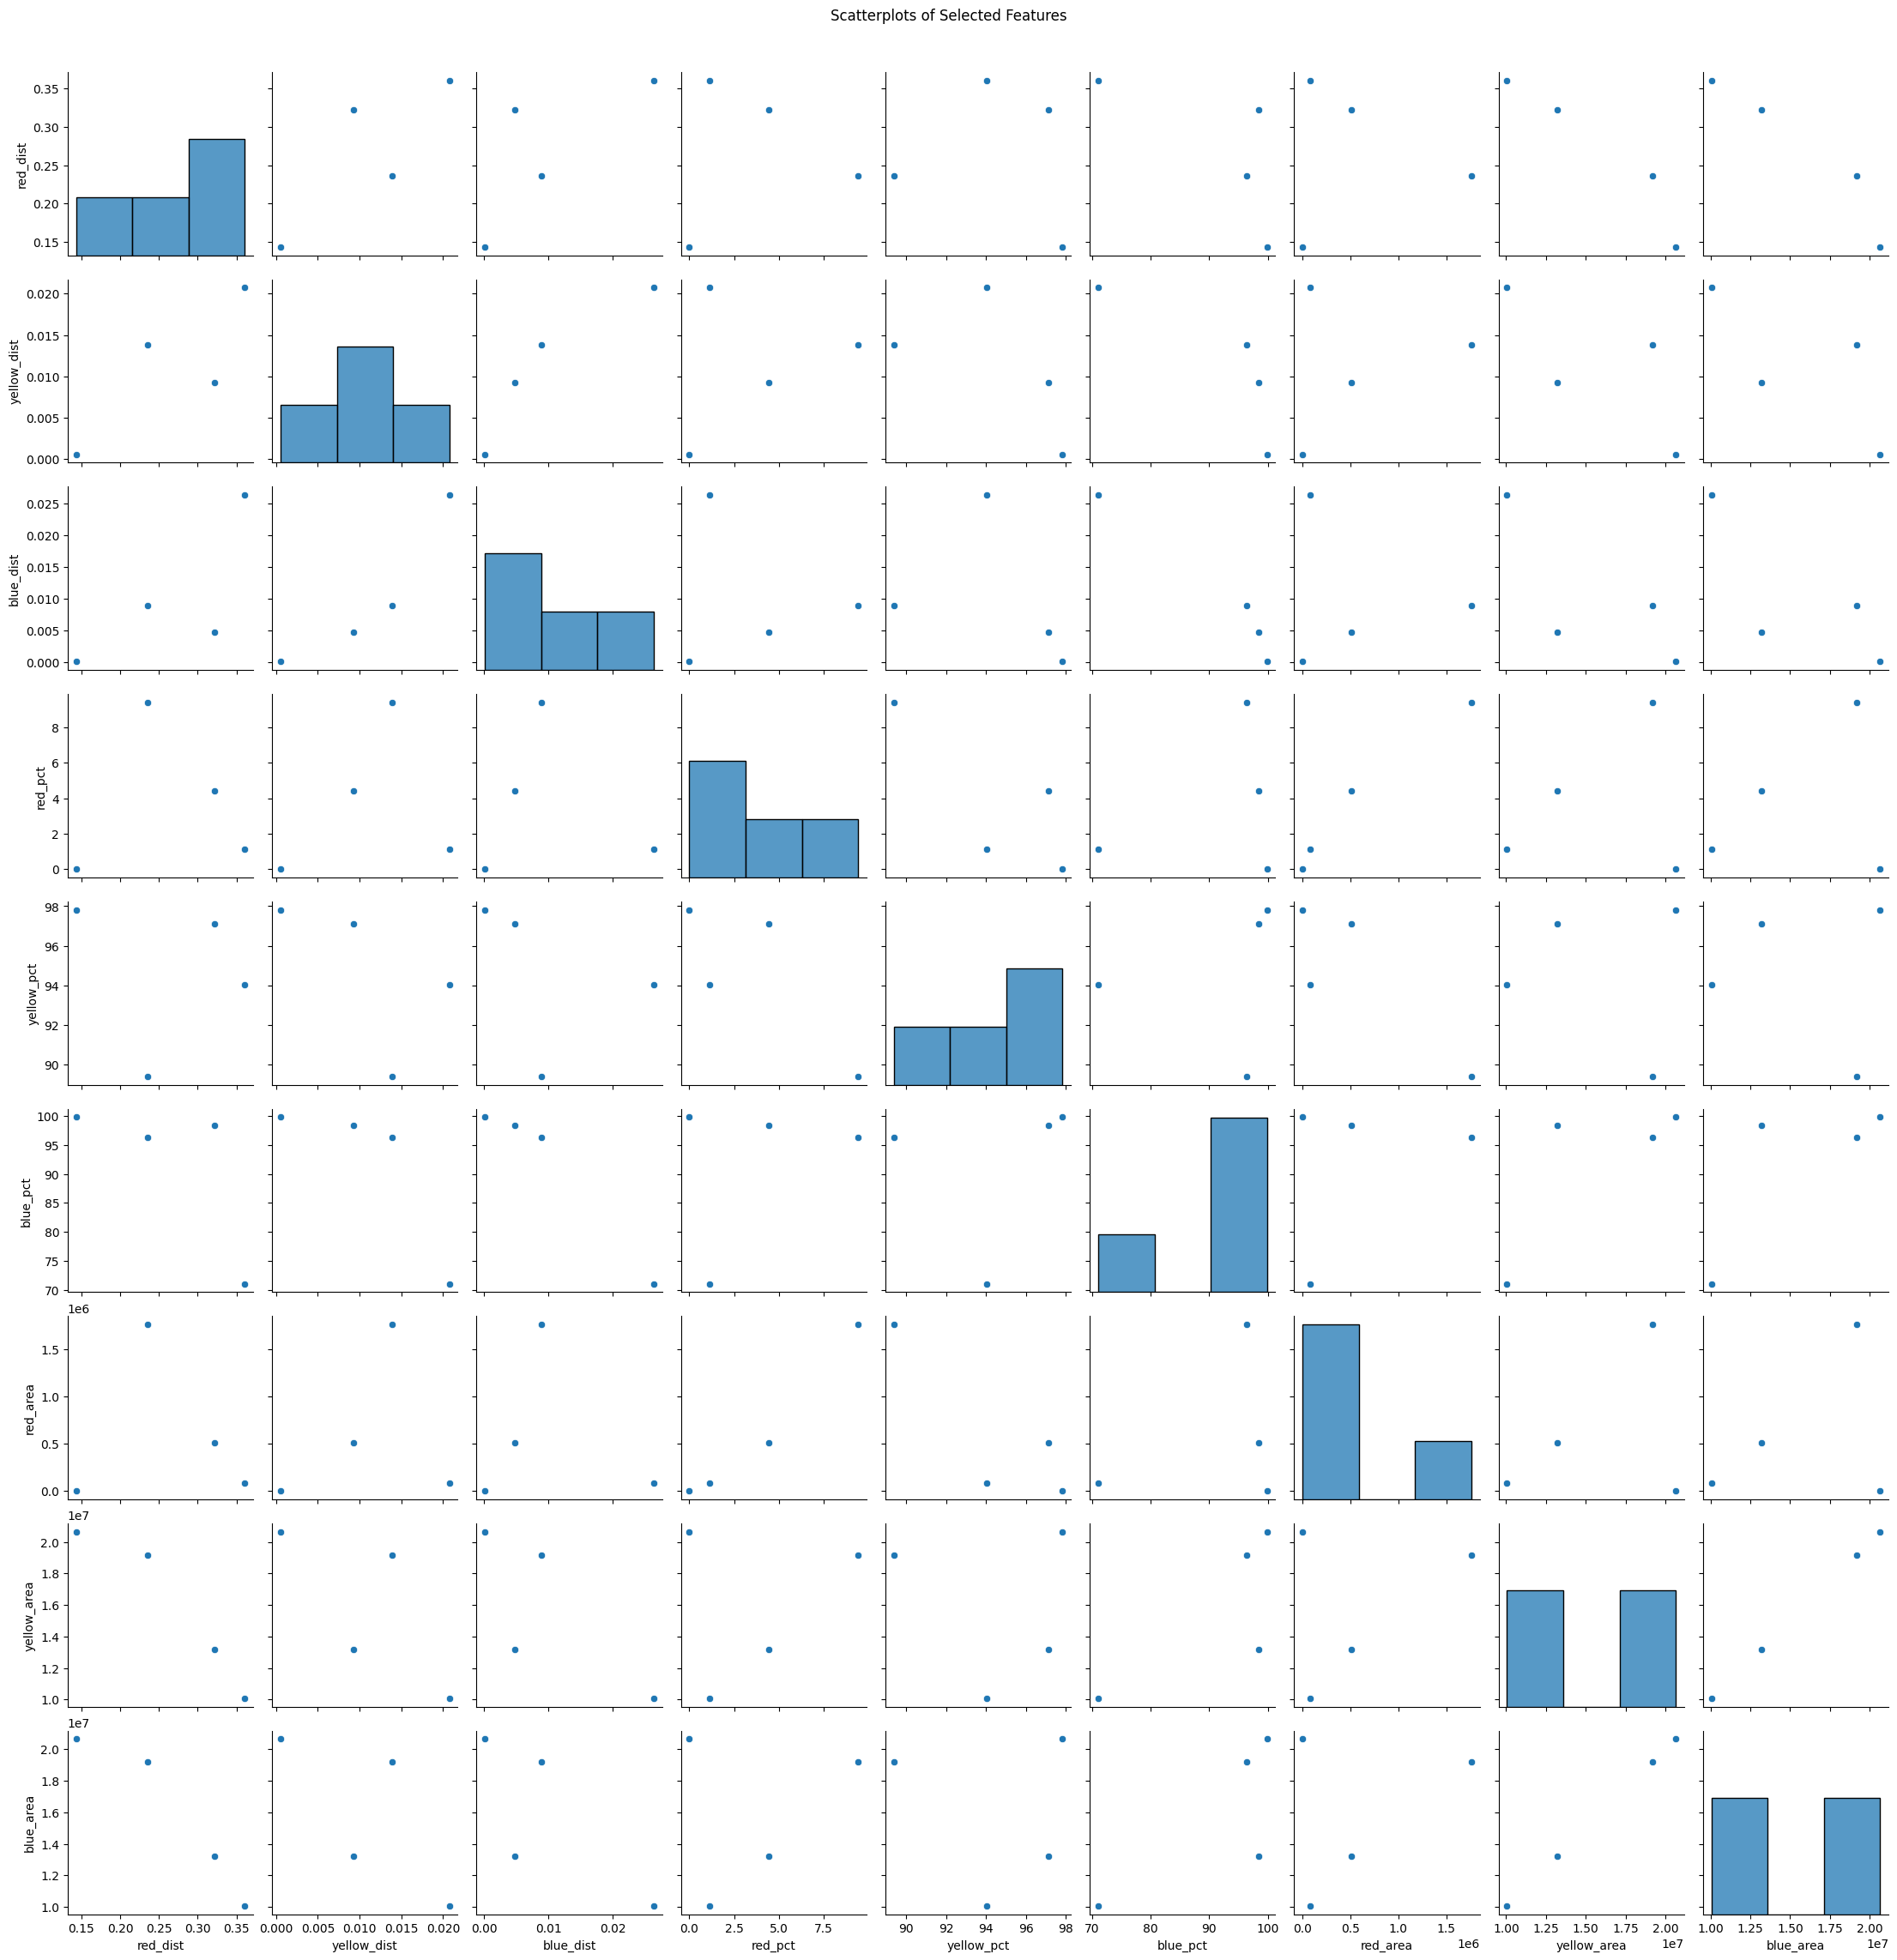

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select features to visualize
scatter_features = [
    "red_dist", "yellow_dist", "blue_dist",
    "red_pct", "yellow_pct", "blue_pct",
    "red_area", "yellow_area", "blue_area"
]

# Pairplot
sns.pairplot(df_features[scatter_features])
plt.suptitle("Scatterplots of Selected Features", y=1.02)
plt.show()


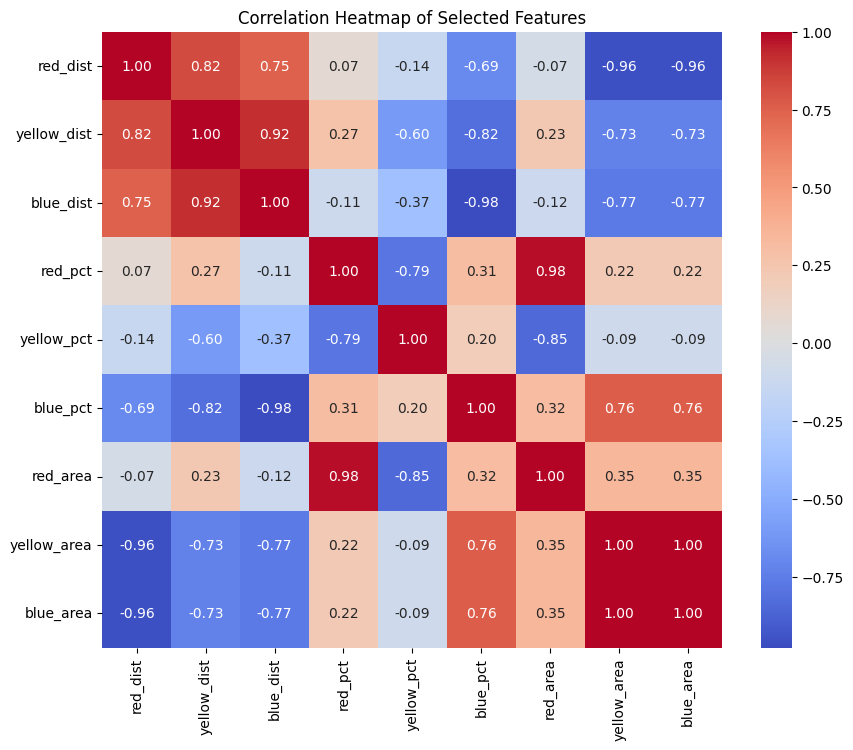

In [74]:
# Compute correlation matrix
corr_matrix = df_features[scatter_features].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Selected Features")
plt.show()
